In [48]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import date, timedelta
import numpy as np

%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams.update({'font.size': 15})

## Czyszczenie danych

In [4]:
def finder(phrase):
    return lambda product_name: str(product_name).find(phrase)

DATA_FILE = 'shumee_mckinsey -Aktualizacja 01.03.xlsx'

df_org = pd.read_excel(DATA_FILE, engine='openpyxl')
df = df_org[df_org['ID zamówienia'].notna()]  # usunięcie wpisów gdzie ID zamówienia == NaN
df = df[df['Nazwa produktu'] != 'Przesyłka pobraniowa']
df = df[df['Nazwa produktu'].map(finder("Kod rabatowy")) == -1]  # usuniecie kodow rabatowych
df = df[df['Miasto'] != 'test']
df = df[df['Miasto'] != 'Test']
df = df[df['Miasto'] != 'TEST']
df = df[df['Miasto'] != 'ssss']
df = df[df['Miasto'] != 'asd']
df = df[df['Miasto'] != 'asdasd']
df = df[df['Miasto'] != 'dsss']
df = df[df['Nazwa produktu'].map(finder("TESTOWY PRODUKT")) == -1]
df = df[df['Nazwa produktu'].map(finder("PRODUKT TESTOWY")) == -1]
df = df[df['Cena'] >= 0]  # usuniecie kodow rabatowych
# akceptuję produkty z ceną 0 zł, ponieważ są to produkty zamówione osobiście lub też telefonicznie

In [7]:
# df.to_csv("shumee_data", index=False)

df = pd.read_csv("shumee_data")
df["Data"] = pd.to_datetime(df["Data"])

## Definiuję użyteczne funkcje

In [25]:
def seasonal_sells(df, name, season):
    """Returns pd.Series with sells of a product of the given name. The sells are partitioned with respect to the season.
    :param df: pd.DataFrame with the Shumee data
    :param name: the name of the product considered
    :param season: possible seasons are ["quarter", "month", "weekday", "hour", "total"]. "Total" means returning the sells from the first day up to the last day, day by day.
    :return: pandas.Series
    """
    
    if season == "quarter":
        sells = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.quarter)
#         sells = sells["Ilość"].sum()
        sells = sells["ID zamówienia"].nunique()
        sells = sells.reindex(range(1,5), fill_value = 0)
        
    elif season == "month":
        sells = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.month)
        # sells = sells["Ilość"].sum()
        sells = sells["ID zamówienia"].nunique()
        sells = sells.reindex(range(1,13), fill_value = 0)
        
    elif season == "weekday":
        sells = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.weekday)
#         sells = sells["Ilość"].sum()
        sells = sells["ID zamówienia"].nunique()
        sells = sells.reindex(range(0,7), fill_value = 0)
        
    elif season =="hour":
        sells = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.hour)
#         sells = sells["Ilość"].sum()
        sells = sells["ID zamówienia"].nunique()
        sells = sells.reindex(range(0,7), fill_value = 0)
        
    elif "total":
        # The first day Shumee started gathering the data
        first_day = df["Data"].dt.date.min()
        # The last day
        last_day = df["Data"].dt.date.max()
        dti_days = pd.date_range(start=first_day, end=last_day, freq="D")
        
        sells = df[df["Nazwa produktu"]==name].groupby(df["Data"].dt.date)
#         sells = sells["Ilość"].sum()
        sells = sells["ID zamówienia"].nunique()
        sells = sells.reindex(dti_days, fill_value = 0)
        
    return sells

def plot_seasonality(df, name, season):
    """Plot the seasonal sells returned by seasonal_sells().
    
    :param df: pd.DataFrame with the Shumee data
    :param name: the name of the product considered
    :param season: possible seasons are ["quarter", "month", "weekday", "hour", "total"]. "Total" means returning the sells from the first day up to the last day, day by day.
    :return: None
    """
    sells = seasonal_sells(df, name, season)
    
    if season == "quarter":
        plt.bar(range(4), sells, tick_label = ["Zima", "Wiosna", "Lato", "Jesień"])
        plt.ylabel("Liczba sprzedanych egzemplarzy")
        plt.title(f"Kwartalna sprzedaż {name}")

    elif season == "month":
        plt.bar(range(12), sells, tick_label = "Sty Lut Mar Kwi Maj Cze Lip Sie Wrz Paz Lis Gru".split(" "))
        plt.ylabel("Liczba sprzedanych egzemplarzy")
        plt.title(f"Miesięczna sprzedaż {name}")
        
    elif season == "week":
        plt.bar(range(7), sells, tick_label = "Pon Wt Śr Czw Pt Sob Nd".split(" "))
        plt.ylabel("Liczba sprzedanych egzemplarzy")
        plt.title(f"Tygodniowa sprzedaż {name}")
        
    elif season =="hour":
        sells.plot(marker="o")
        plt.ylabel("Liczba sprzedanych egzemplarzy")
        plt.xlabel("Godzina")
        plt.title(f"Godzinna sprzedaż {name}")
        
    elif "total":
        sells.plot()
        plt.ylabel("Liczba sprzedanych egzemplarzy")
        plt.title(f"Sprzedaż {name}")

## Usunięcie produktów sprzedawanych mniej niż rok

In [53]:
sells_duration = df["Data"].groupby(df["Nazwa produktu"]).max() - df["Data"].groupby(df["Nazwa produktu"]).min()

In [60]:
# Lista nazw produktów sprzedawanych co najmniej rok:
longer_than_year = sells_duration[sells_duration > timedelta(days=365)].index

In [63]:
df = df[df['Nazwa produktu'].map(lambda name: True if name in longer_than_year else False)]

## Tworzę DataFrame, w którym trzymam sezonowość różnych produktów

In [76]:
# product_names = df["Nazwa produktu"].unique()
sells_threshold = 50
product_names = df.groupby("Nazwa produktu")["ID zamówienia"].nunique()
# product_names = df.groupby("Nazwa produktu")["Ilość"].sum()
product_names = product_names[product_names > sells_threshold].index

# seasonal_variances = {'quarter' : [],
#                       'month' : [],
#                       'weekday' : [],                
#                       'hour' : []
#                      }
# total_sells = []

seasonal_variances = {'quarter' : [],
                      'month' : []
                     }

for i, name in enumerate(product_names):
        
    # total_sells.append(df[df["Nazwa produktu"]==name]["Ilość"].sum())
    
    for season, var in seasonal_variances.items():
        var.append(seasonal_sells(df, name, season).var())

In [77]:
seasonality = pd.DataFrame(data = seasonal_variances,
                           index = product_names)
                            
seasonality.head()

,quarter,month
Nazwa produktu,,
2-częściowy garnitur biznesowy męski czarny rozmia,11.000000,4.151515
2-częściowy garnitur męski z krawatem biały rozmia,18.000000,4.242424
6 Bambusowych brązowych podkładek pod talerze 30 x,150.666667,28.787879
Aluminiowe koło podporowe/manewrowe do przyczepy 1,148.666667,24.909091
Automatyczny system nawadniania ze zraszaczem i wł,2458.916667,327.719697


## Największa sezonowość kwartalna

In [79]:
print("Największa sezonowość kwartalna:")
seasonality["quarter"].sort_values(ascending=False)[:10]

Największa sezonowość kwartalna:


Nazwa produktu
Zaczepy do przyczepki rowerowej, 2 szt., żelazne      3652.000000
Daszek do automatycznej kosiarki 77x103x46 cm         3362.000000
Zaczep do przyczepki rowerowej żelazny                3170.916667
Automatyczny system nawadniania ze zraszaczem i wł    2458.916667
Wypukłe lustro drogowe, 30 cm, czarne                 1444.250000
Lampa sufitowa, plafon, białe i bezbarwne listki 3    1350.916667
Stolik barowy z półkami, biały, 110 x 50 x 103 cm     1208.666667
Fontanna pokojowa ze światłem LED, żywica syntetyc    1054.250000
Zestaw zawieszenia tła 300 cm szeroki bez płótna       977.583333
Zadaszenie altany, 2-poziomowe, 310 g/m, 3 x 3 m,      958.916667
Name: quarter, dtype: float64

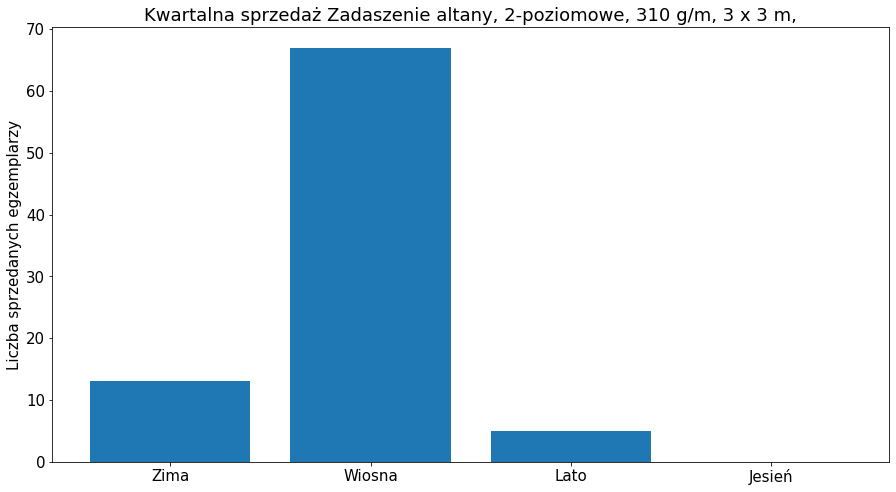

In [84]:
plot_seasonality(df, seasonality["quarter"].sort_values(ascending=False).index[9], "quarter")

## Największa sezonowość miesięczna

In [85]:
print("Największa sezonowość kwartalna:")
seasonality["month"].sort_values(ascending=False)[:10]

Największa sezonowość kwartalna:


Nazwa produktu
Zaczepy do przyczepki rowerowej, 2 szt., żelazne      558.909091
Zaczep do przyczepki rowerowej żelazny                453.840909
Daszek do automatycznej kosiarki 77x103x46 cm         398.606061
Automatyczny system nawadniania ze zraszaczem i wł    327.719697
Kosz do segregacji śmieci z pedałami, stal nierdze    218.992424
Wypukłe lustro drogowe, 30 cm, czarne                 214.568182
Lampa sufitowa, plafon, białe i bezbarwne listki 3    194.265152
Półki ścienne, 3 szt., białe, płyta wiórowa           163.878788
Zestaw zawieszenia tła 300 cm szeroki bez płótna      158.810606
Fontanna pokojowa ze światłem LED, żywica syntetyc    148.992424
Name: month, dtype: float64

## Jakie przedmioty sprzedawały się najczęściej?

In [5]:
products_sells = df.groupby("Nazwa produktu")["Ilość"].sum()
products_sells = products_sells.sort_values(ascending=False)
products_sells.head(20)

Nazwa produktu
Wypukłe lustro drogowe, 30 cm, czarne                                                                     479.0
CZYSTA KABINA PRYSZNICOWA 500 ml Sann Profi                                                               444.0
Uchwyt do telewizora z podstawką, 400 x 400 mm, 23                                                        412.0
PEPCO - Koc polarowy 130x160cm                                                                            358.0
Lampa sufitowa, plafon, białe i bezbarwne listki 3                                                        355.0
Lampa stroboskopowa do ustawiania zapłonu                                                                 303.0
Najazd kablowy, 2-kanałowy, gumowy, 101,5 cm 14283                                                        281.0
Shumee Kommode Geräumiger Schrank 5 Schubladen 40x70x112 cm Malwa M5 Sideboard Anrichte Highboard Weiß    275.0
Najazd kablowy, 2-kanałowy, gumowy, 101,5 cm                                             

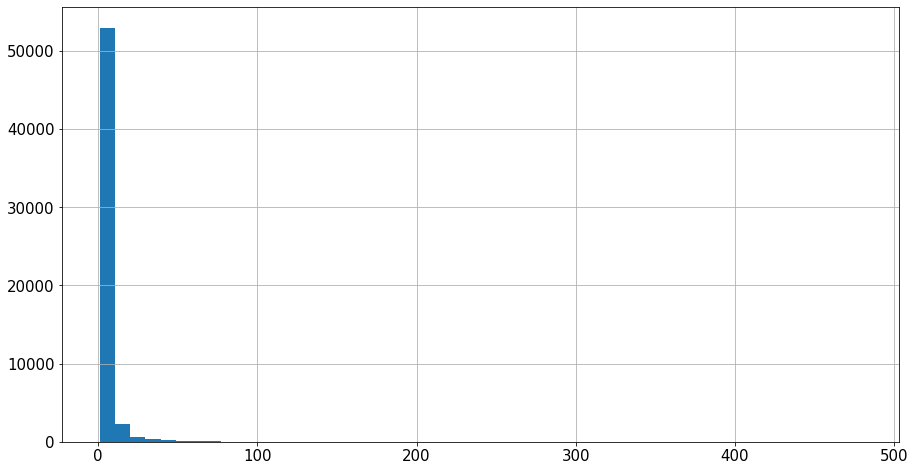

In [6]:
products_sells.hist(bins=50)
plt.show()

In [69]:
print(f"Produtków sprzedanych w liczbie mniejszej niż 10 jest {(products_sells < 10).sum()}")
print(f"To aż {100*(products_sells < 10).sum()/products_sells.shape[0]:.0f}% wszystkich produktów!")

Produtków sprzedanych w liczbie mniejszej niż 10 jest 52383
To aż 92% wszystkich produktów


Zatem konieczne jest pogrupowanie produktów

## Przyjrzyjmy się sprzedaży produktów, których sprzedano najwięcej sztuk

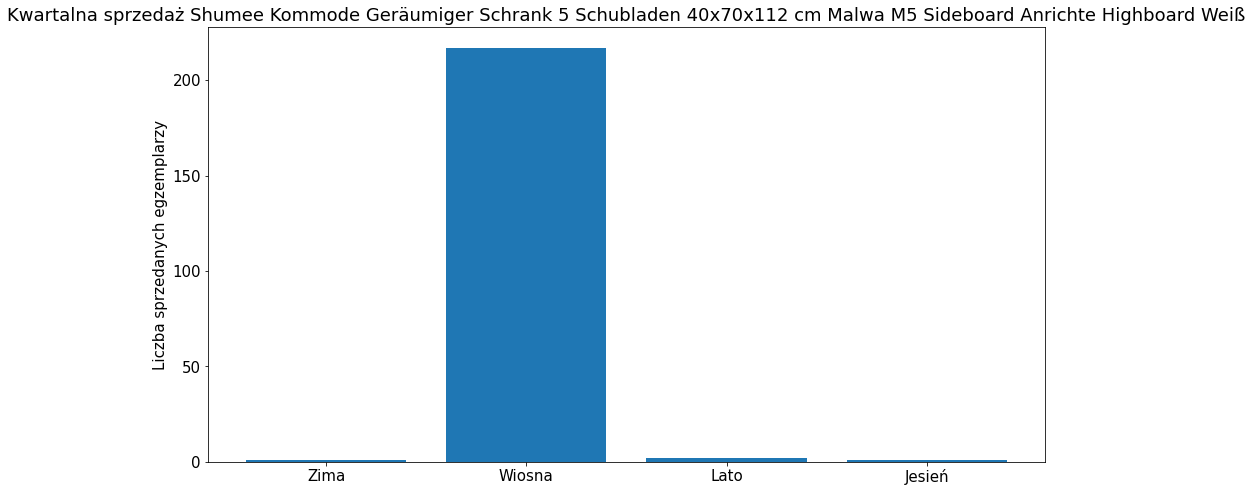

In [37]:
plot_seasonality(df, seasonality["quarter"].sort_values(ascending=False).index[0], "quarter")

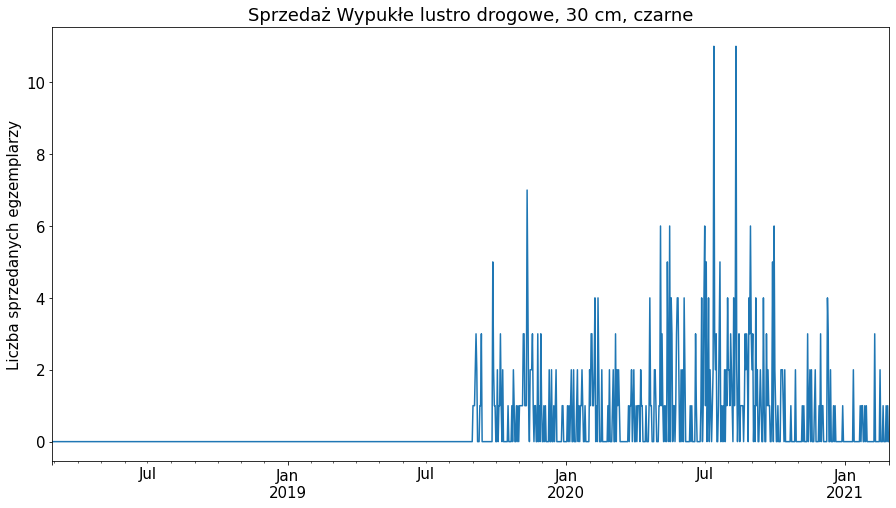

In [12]:
name = "Wypukłe lustro drogowe, 30 cm, czarne"
plot_seasonality(df, name = name, season = "total")

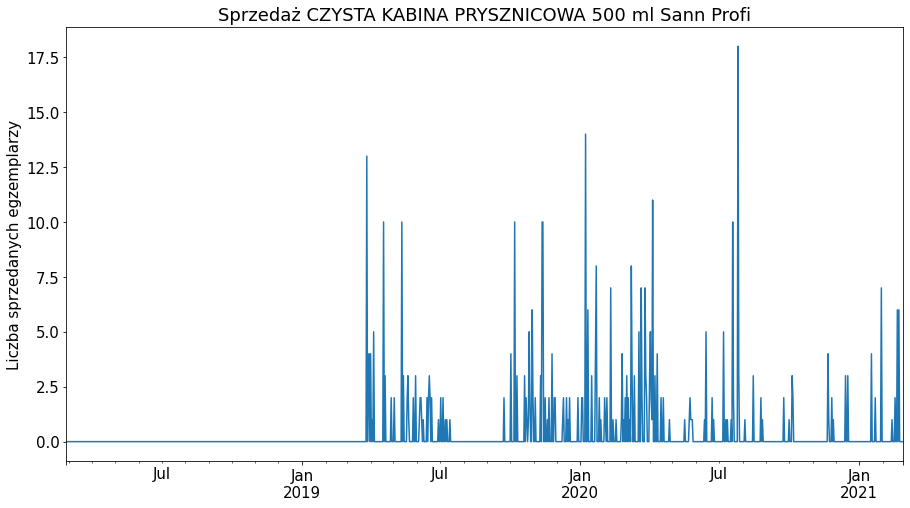

In [158]:
name = "CZYSTA KABINA PRYSZNICOWA 500 ml Sann Profi"
plot_seasonality(name = name, season = "total")

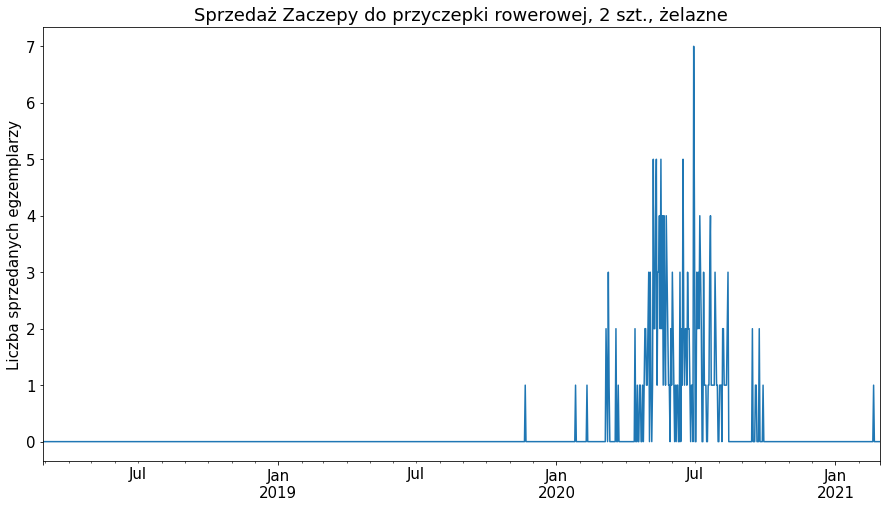

In [159]:
name = "Zaczepy do przyczepki rowerowej, 2 szt., żelazne"
plot_seasonality(name = name, season = "total")

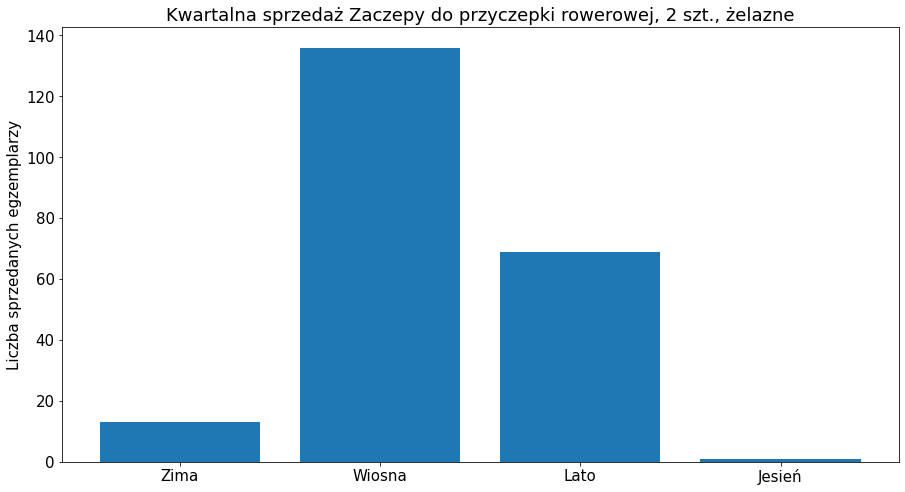

In [213]:
name = "Zaczepy do przyczepki rowerowej, 2 szt., żelazne"
plot_seasonality(name = name, season = "quarter")

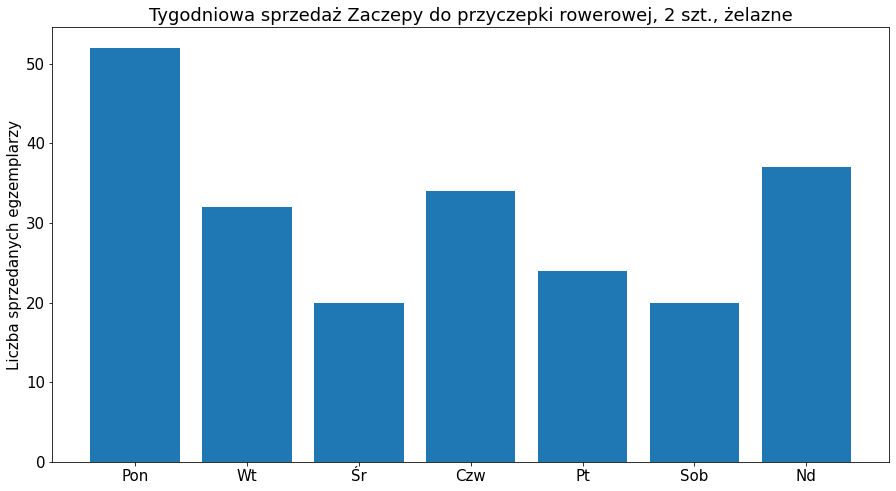

In [214]:
name = "Zaczepy do przyczepki rowerowej, 2 szt., żelazne"
plot_seasonality(name = name, season = "week")

In [28]:
seasonality.idxmax()

quarter    Shumee Kommode Geräumiger Schrank 5 Schubladen...
month      Shumee Kommode Geräumiger Schrank 5 Schubladen...
weekday    Uchwyt do telewizora z podstawką, 400 x 400 mm...
hour               Lampa stroboskopowa do ustawiania zapłonu
dtype: object

In [29]:
print("Największa sezonowość kwartalna:")
seasonality["quarter"].sort_values(ascending=False)

Największa sezonowość kwartalna:


Nazwa produktu
Shumee Kommode Geräumiger Schrank 5 Schubladen 40x70x112 cm Malwa M5 Sideboard Anrichte Highboard Weiß    11628.250000
Uchwyt do telewizora z podstawką, 400 x 400 mm, 23                                                         6738.250000
Skrzynka na listy ze stali nierdzewnej                                                                     6110.916667
Zaczepy do przyczepki rowerowej, 2 szt., żelazne                                                           3652.000000
Shumee Kommode Schrank M3 3 Schubladen 40x70x77 cm Sideboard Anrichte Highboard Farbe Weiß                 3366.916667
                                                                                                              ...     
Wieszak na ręczniki z 6 rurkami, stal nierdzewna                                                             72.916667
Przenośny fotel kosmetyczny, ekoskóra, 185 x 78 x                                                            72.250000
Elastyczny pokrowiec na fotel, z 

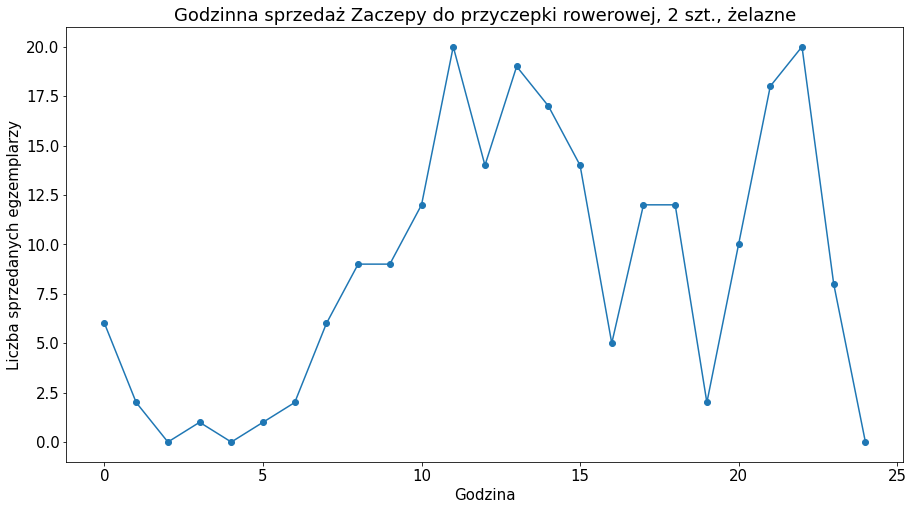

In [215]:
name = "Zaczepy do przyczepki rowerowej, 2 szt., żelazne"
plot_seasonality(name = name, season = "hour")

In [30]:
print("Największa sezonowość miesięczna:")
seasonality["month"].sort_values(ascending=False)

Największa sezonowość miesięczna:


Nazwa produktu
Shumee Kommode Geräumiger Schrank 5 Schubladen 40x70x112 cm Malwa M5 Sideboard Anrichte Highboard Weiß    3216.265152
Skrzynka na listy ze stali nierdzewnej                                                                     822.204545
Uchwyt do telewizora z podstawką, 400 x 400 mm, 23                                                         769.719697
Shumee Kommode Schrank M3 3 Schubladen 40x70x77 cm Sideboard Anrichte Highboard Farbe Weiß                 704.628788
Intex Basen Metal Frame, 366 x 76 cm, 28210NP                                                              601.545455
                                                                                                             ...     
Elastyczny pokrowiec na fotel, z dżerseju, antracy                                                          16.818182
Zestaw stolików kawowych, 2 szt., biały, lite drew                                                          14.265152
Wieszak na ręczniki z 6 rurkami, stal nie

In [31]:
print("Największa sezonowość tygodniowa:")
seasonality["weekday"].sort_values(ascending=False)[:10]

Największa sezonowość tygodniowa:


Nazwa produktu
Uchwyt do telewizora z podstawką, 400 x 400 mm, 23                                                        370.666667
Shumee Kommode Schrank M3 3 Schubladen 40x70x77 cm Sideboard Anrichte Highboard Farbe Weiß                205.666667
Lampa stroboskopowa do ustawiania zapłonu                                                                 199.904762
Wypukłe lustro drogowe, 30 cm, czarne                                                                     154.238095
Zestaw zawieszenia tła 300 cm szeroki bez płótna                                                          134.333333
Lampa sufitowa, plafon, białe i bezbarwne listki 3                                                        125.476190
Zaczepy do przyczepki rowerowej, 2 szt., żelazne                                                          122.809524
Automatyczny system nawadniania ze zraszaczem i wł                                                        118.476190
Intex Basen Metal Frame, 366 x 76 cm, 28210NP    

In [33]:
print("Największa sezonowość godzinna:")
seasonality["hour"].sort_values(ascending=False)[:10]

Największa sezonowość godzinna:


Nazwa produktu
Lampa stroboskopowa do ustawiania zapłonu                                                     7.952381
Uchwyt do telewizora z podstawką, 400 x 400 mm, 23                                            5.666667
Dywan pleciony z juty, 90 cm, okrągły                                                         4.904762
Shumee Kommode Schrank M3 3 Schubladen 40x70x77 cm Sideboard Anrichte Highboard Farbe Weiß    4.238095
Zaczepy do przyczepki rowerowej, 2 szt., żelazne                                              4.238095
Toaletka z obrotowym, owalnym lustrem, MDF 60627                                              3.476190
Konsola z trzema szufladami, biała                                                            3.476190
Shumee Schrank 120 cm M6 6 Schubladen Kommode Großraum Modern Weiß                            3.285714
Fontanna pokojowa ze światłem LED, żywica syntetyc                                            2.476190
Sztuczny bluszcz 90 cm x2                                 

Suma sprzedaży      358.000000
Kwartał           14895.250000
Miesiąc            4633.138889
Dzień tyg.          774.693878
Godzina             407.737600
Name: PEPCO - Koc polarowy 130x160cm, dtype: float64


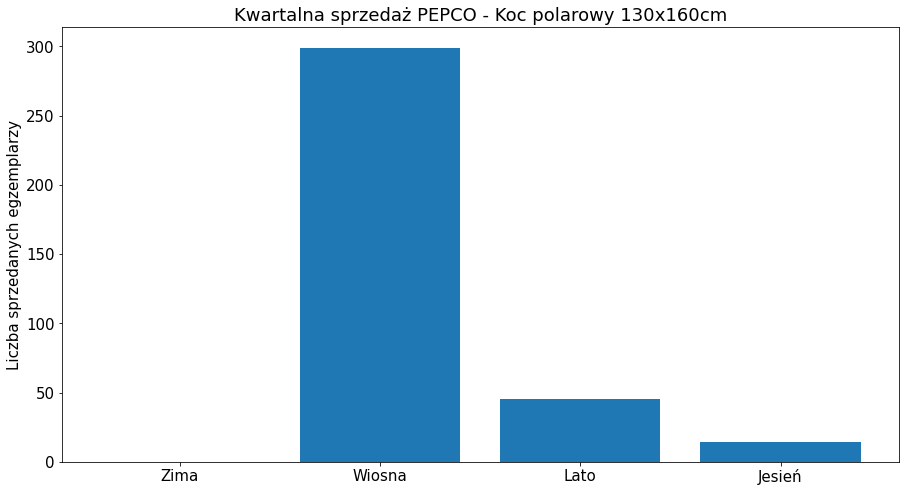

In [223]:
name = "PEPCO - Koc polarowy 130x160cm"
plot_seasonality(name = name, season = "quarter")
print(seasonality.loc[name])

Suma sprzedaży    105.000000
Kwartał            17.187500
Miesiąc            15.354167
Dzień tyg.         76.000000
Godzina            15.600000
Name: Elastyczny pokrowiec na sofę, z dżerseju, beżowy, dtype: float64


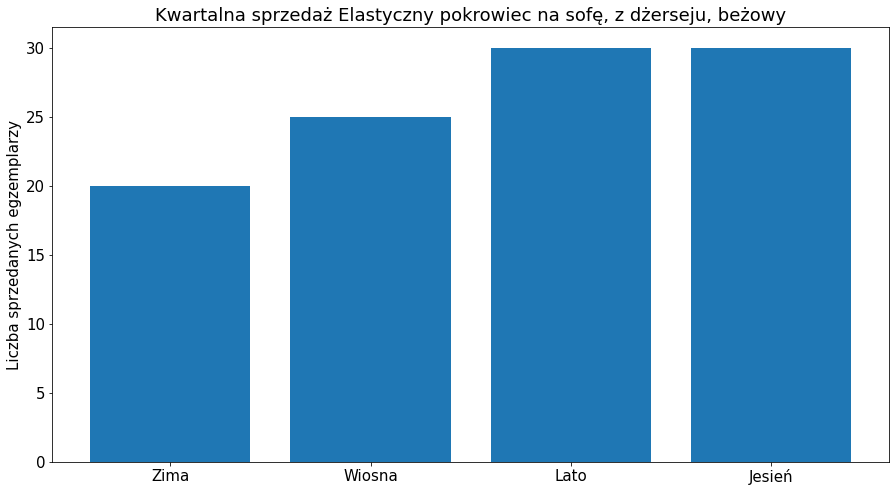

In [222]:
name="Elastyczny pokrowiec na sofę, z dżerseju, beżowy"
plot_seasonality(name = name, season = "quarter")
print(seasonality.loc[name])

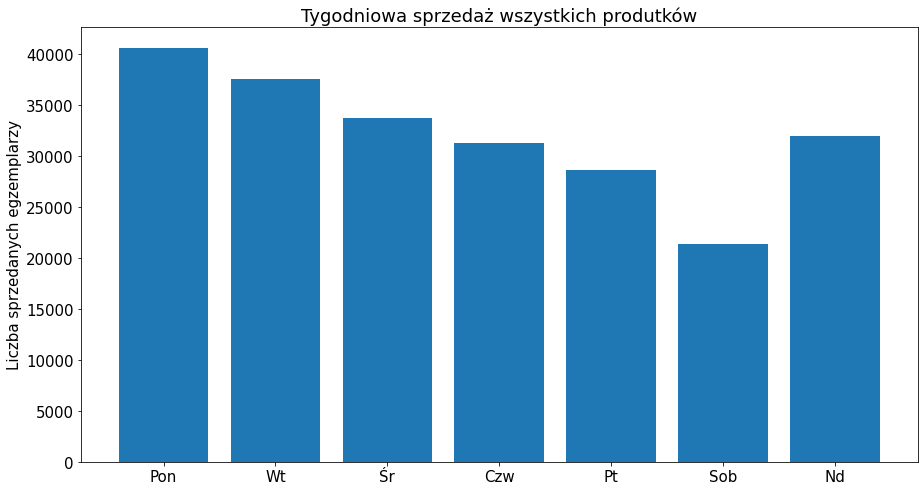

In [236]:
df1prod = df.groupby(df["Data"].dt.weekday)
df1prod = df1prod["Ilość"].sum().reindex(range(0,7), fill_value = 0)
plt.bar(range(7), df1prod, tick_label = "Pon Wt Śr Czw Pt Sob Nd".split(" "))
plt.ylabel("Liczba sprzedanych egzemplarzy")
plt.title(f"Tygodniowa sprzedaż wszystkich produtków")
plt.show()

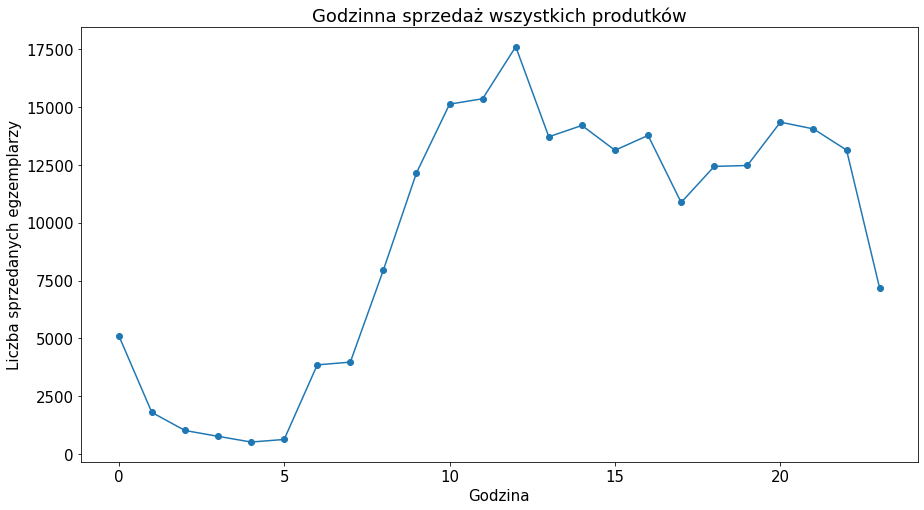

In [257]:
df1prod = df.groupby(df["Data"].dt.hour)
df1prod = df1prod["Ilość"].sum().reindex(range(0,24), fill_value = 0)
df1prod.plot(marker="o")
plt.ylabel("Liczba sprzedanych egzemplarzy")
plt.xlabel("Godzina")
plt.title(f"Godzinna sprzedaż wszystkich produtków")
plt.show()

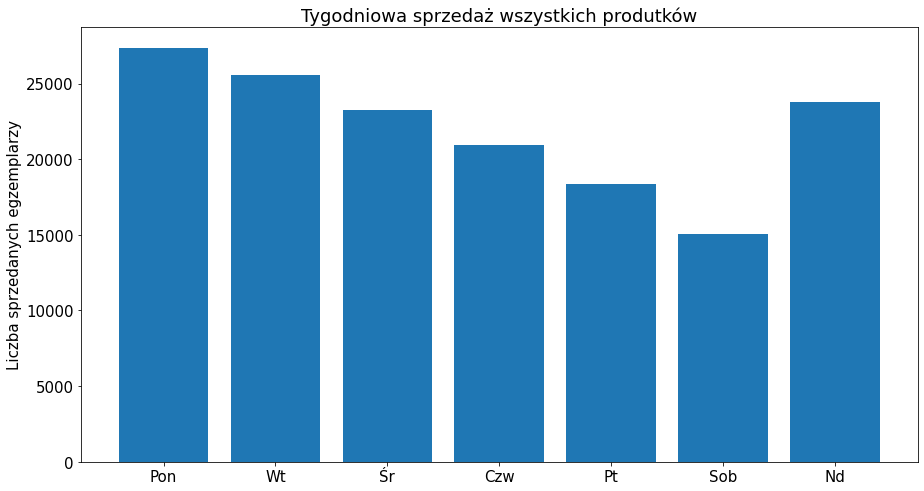

In [246]:
df1prod = df.groupby(df["Data"].dt.weekday)
df1prod = df1prod["ID zamówienia"].nunique().reindex(range(0,7), fill_value = 0)
plt.bar(range(7), df1prod, tick_label = "Pon Wt Śr Czw Pt Sob Nd".split(" "))
plt.ylabel("Liczba sprzedanych egzemplarzy")
plt.title(f"Tygodniowa sprzedaż wszystkich produtków")
plt.show()

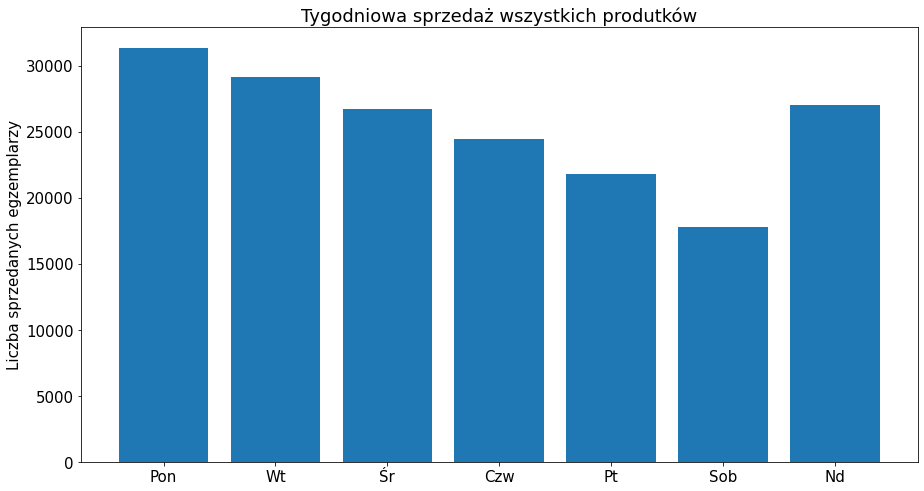

In [253]:
df1prod = df["Nazwa produktu"].groupby(df["Data"].dt.weekday).count()
# df1prod = df1prod["ID zamówienia"].nunique().reindex(range(0,7), fill_value = 0)
plt.bar(range(7), df1prod, tick_label = "Pon Wt Śr Czw Pt Sob Nd".split(" "))
plt.ylabel("Liczba sprzedanych egzemplarzy")
plt.title(f"Tygodniowa sprzedaż wszystkich produtków")
plt.show()